In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from config import Archive_Path
from os.path import join
from glob import glob
from tqdm import tqdm

# Sanitizing the Data
Here I will preprocess (apply all the cuts, etc) to all the data and dump it on a Data.h5 file for later use with the respective keys (BKG/SIGNAL)

In [2]:
# Getting all the path's of the BGK files
BKG_PATHS = glob(join(Archive_Path, "BKG-singletop","*.csv"), recursive=True)


# Getting all the path's of the SIGNAL files
SIGNAL_PATHS = glob(join(Archive_Path, "SIGNAL-MonoTop_Resonant","*.csv"), recursive=True)

In [3]:
relevant_columns = [
    'Jet_Multi',
    'Jet1_Mass',
    'Jet2_Mass',
    'Jet3_Mass',
    'Jet4_Mass',
    'Jet5_Mass',
    'Jet1_Eta',
    'Jet2_Eta',
    'Jet3_Eta',
    'Jet4_Eta',
    'Jet5_Eta',
    'Jet1_Phi',
    'Jet2_Phi',
    'Jet3_Phi',
    'Jet4_Phi',
    'Jet5_Phi',
    'Jet1_PT',
    'Jet2_PT',
    'Jet3_PT',
    'Jet4_PT',
    'Jet5_PT',
    'Jet1_BTag',
    'Jet2_BTag',
    'Jet3_BTag',
    'Jet4_BTag',
    'Jet5_BTag',
    'Muon_Multi',
    'Muon1_PT',
    'Muon2_PT',
    'Muon1_Eta',
    'Muon2_Eta',
    'Muon1_Phi',
    'Muon2_Phi',
    'Electron_Multi',
    'Electron1_PT',
    'Electron2_PT',
    'Electron1_Eta',
    'Electron2_Eta',
    'Electron1_Phi',
    'Electron2_Phi',
    'MissingET_MET',
    'MissingET_Phi',
    'ScalarHT_HT',
    'gen_xsec',

    'CaloJet08_Multi',
    'CaloJet081_PT',
    'CaloJet082_PT',
    'CaloJet083_PT',
    'CaloJet084_PT',
    'CaloJet085_PT',
    'CaloJet081_Mass',
    'CaloJet082_Mass',
    'CaloJet083_Mass',
    'CaloJet084_Mass',
    'CaloJet085_Mass',
    'CaloJet081_Eta',
    'CaloJet082_Eta',
    'CaloJet083_Eta',
    'CaloJet084_Eta',
    'CaloJet085_Eta',
    'CaloJet081_Phi',
    'CaloJet082_Phi',
    'CaloJet083_Phi',
    'CaloJet084_Phi',
    'CaloJet085_Phi',
    'CaloJet081_Tau1',
    'CaloJet081_Tau2',
    'CaloJet081_Tau3',
    'CaloJet081_Tau4',
    'CaloJet081_Tau5'
    ]

In [4]:
def filter_data(files, apply_cuts=True):
    """
    files - list with every path for the files
    """
    # Inicialize variables
    data = []
    count_original = 0


    for file in tqdm(files, total=len(files), desc="Processing..."):
        temp = pd.read_csv(file)
        file_name = os.path.basename(file)

        to_remove = list(set(temp.columns) - set(relevant_columns))

        temp.drop(to_remove, axis=1, inplace=True)

        # Updating the size of the original full dataset
        count_original += temp.shape[0]

        # Making the label column 
        # 1 - Signal
        # 0 - Background
        if 'BKG' in file:
            temp['Label'] = 0
        if 'SIGNAL' in file:
            temp['Label'] = 1

        # Calculating weights
        temp["gen_xsec"] = temp["gen_xsec"].mean() / temp.shape[0]
        temp.rename(columns={"gen_xsec":"Weights"}, inplace=True)
        print(" [Info]", file_name, "\t->", temp['Weights'][0])

        # Extra variable with the filename
        temp['Name'] = file_name

        # Append To List
        data.append(temp)

        # Delete variables to release RAM
        del temp
        del to_remove
    print("\n")
    # Concat everything
    data = pd.concat(data)

    # Cut's Stats
    print("[Cut] 0 Leptons drop ratio:\t", (1-(data[(data['Electron_Multi'] + data['Muon_Multi']) == 0].shape[0]/data.shape[0]))*100, "%")
    print("[Cut] At least 1 B-Tag drop ratio:\t", (1-(data[(data['Jet1_BTag'] + data['Jet2_BTag'] + data['Jet3_BTag'] + data['Jet4_BTag'] + data['Jet5_BTag']) >= 1].shape[0]/data.shape[0]))*100, "%")
    print("[Cut] At least 1 FatJet (CaloJet08) drop ratio:\t", (1-(data[data['CaloJet08_Multi'] >= 1].shape[0]/data.shape[0]))*100, "%")

    # Apply Cuts
    if apply_cuts:
        data = data[(data['Electron_Multi'] + data['Muon_Multi']) == 0] # 0 Leptões
        data = data[(data['Jet1_BTag'] + data['Jet2_BTag'] + data['Jet3_BTag'] + data['Jet4_BTag'] + data['Jet5_BTag']) >= 1] # Pelo menos 1 B-Tag
        data = data[data['CaloJet08_Multi'] >= 1] # PELO MENOS 1 FATJET




    # Final count and drop percentage
    count_final = data.shape[0]

    print("\nTOTAL Drop Rate:", (1-(count_final/count_original))*100, "%")
    return data


## Processing the data 

In [5]:
BKG_DATA = filter_data(BKG_PATHS)

Processing...: 100%|██████████| 6/6 [05:32<00:00, 55.44s/it] [Info] Background_ZZ_FullyHadronic.csv 	-> 2.747050000000003e-06



[Cut] 0 Leptons drop ratio:	 0.3438333333333321 %
[Cut] At least 1 B-Tag drop ratio:	 81.25281666666666 %
[Cut] At least 1 FatJet (CaloJet08) drop ratio:	 2.276066666666665 %

TOTAL Drop Rate: 81.38926666666666 %


In [6]:
SIGNAL_DATA = filter_data(SIGNAL_PATHS)

Processing...: 100%|██████████| 2/2 [00:54<00:00, 27.03s/it] [Info] MonoTop_ResonantModel_15.csv 	-> 2.064088888888889e-08



[Cut] 0 Leptons drop ratio:	 0.5268999999999968 %
[Cut] At least 1 B-Tag drop ratio:	 34.2679 %
[Cut] At least 1 FatJet (CaloJet08) drop ratio:	 0.0074000000000018495 %

TOTAL Drop Rate: 34.4409 %


### Saving the data on Data.h5

In [7]:
BKG_DATA.to_hdf(join(Archive_Path,"Data.h5"), key="BKG") 

In [8]:
SIGNAL_DATA.to_hdf(join(Archive_Path,"Data.h5"), key="SIGNAL")

# Exploring the processed data

### Loading the data

In [9]:
BKG_DATA = pd.read_hdf(join(Archive_Path,"Data.h5"), key="BKG").drop(columns=['Name'])
SIGNAL_DATA = pd.read_hdf(join(Archive_Path,"Data.h5"), key="SIGNAL").drop(columns=['Name'])

In [10]:
BKG_DATA.describe()

,CaloJet08_Multi,CaloJet081_PT,CaloJet082_PT,CaloJet083_PT,CaloJet084_PT,CaloJet085_PT,CaloJet081_Mass,CaloJet082_Mass,CaloJet083_Mass,CaloJet084_Mass,...,Electron2_PT,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,Weights,Label
count,1.116644e+06,1.116644e+06,1.116644e+06,1.116644e+06,1.116644e+06,1.116644e+06,1.116644e+06,1.116644e+06,1.116644e+06,1.116644e+06,...,1116644.0,1116644.0,1116644.0,1116644.0,1116644.0,1.116644e+06,1.116644e+06,1.116644e+06,1.116644e+06,1116644.0
mean,4.394837e+00,1.171491e+02,8.625560e+01,5.341845e+01,3.313565e+01,1.766487e+01,2.703682e+01,1.920053e+01,1.122843e+01,7.051825e+00,...,0.0,0.0,0.0,0.0,0.0,2.657790e+01,-9.916593e-04,4.951466e+02,1.453386e-03,0.0
std,1.463798e+00,7.447976e+01,5.781250e+01,3.184850e+01,2.555688e+01,2.092294e+01,2.433080e+01,1.839823e+01,9.107656e+00,6.676008e+00,...,0.0,0.0,0.0,0.0,0.0,2.108948e+01,1.813652e+00,2.015508e+02,4.964128e-03,0.0
min,1.000000e+00,2.501421e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.157919e-05,-4.315837e-05,-2.642900e-05,-3.051758e-05,...,0.0,0.0,0.0,0.0,0.0,3.349080e-02,-3.141589e+00,4.780229e+01,2.747050e-06,0.0
25%,3.000000e+00,7.144004e+01,5.307305e+01,3.632871e+01,0.000000e+00,0.000000e+00,1.173261e+01,8.781013e+00,5.659381e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,1.289664e+01,-1.571140e+00,3.631114e+02,2.242673e-04,0.0
50%,4.000000e+00,9.781636e+01,7.247948e+01,5.029757e+01,3.521568e+01,0.000000e+00,1.941832e+01,1.411946e+01,9.641507e+00,6.409698e+00,...,0.0,0.0,0.0,0.0,0.0,2.165677e+01,-3.520703e-03,4.698854e+02,2.242673e-04,0.0
75%,5.000000e+00,1.376553e+02,1.003334e+02,6.740939e+01,4.819059e+01,3.409551e+01,3.318384e+01,2.286771e+01,1.487254e+01,1.081008e+01,...,0.0,0.0,0.0,0.0,0.0,3.429392e+01,1.569751e+00,5.920071e+02,2.242673e-04,0.0
max,1.300000e+01,2.086605e+03,1.694584e+03,8.493058e+02,4.599241e+02,2.559038e+02,4.883367e+02,5.322263e+02,2.131065e+02,1.560580e+02,...,0.0,0.0,0.0,0.0,0.0,1.022667e+03,3.141587e+00,4.335648e+03,2.453500e-02,0.0


In [11]:
SIGNAL_DATA.describe()

,CaloJet08_Multi,CaloJet081_PT,CaloJet082_PT,CaloJet083_PT,CaloJet084_PT,CaloJet085_PT,CaloJet081_Mass,CaloJet082_Mass,CaloJet083_Mass,CaloJet084_Mass,...,Electron2_PT,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,Weights,Label
count,655591.000000,655591.000000,655591.000000,655591.000000,655591.000000,655591.000000,655591.000000,655591.000000,655591.000000,655591.000000,...,655591.0,655591.0,655591.0,655591.0,655591.0,655591.000000,655591.000000,655591.000000,6.555910e+05,655591.0
mean,2.478362,320.775793,69.072220,22.644339,7.119987,1.918704,93.515697,13.476550,4.713387,1.600791,...,0.0,0.0,0.0,0.0,0.0,351.006572,-0.000051,573.642290,3.096441e-08,1.0
std,1.149893,121.962272,72.945184,33.242875,17.215229,8.529841,48.223561,17.236723,7.569281,4.173745,...,0.0,0.0,0.0,0.0,0.0,111.867555,1.813410,183.042001,1.787424e-08,0.0
min,1.000000,26.125969,0.000000,0.000000,0.000000,0.000000,-0.000061,-0.000022,-0.000015,-0.000004,...,0.0,0.0,0.0,0.0,0.0,0.365967,-3.141570,82.335991,2.064089e-08,1.0
25%,2.000000,235.132179,29.330849,0.000000,0.000000,0.000000,57.877253,3.321538,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,282.872879,-1.570362,464.421967,2.064089e-08,1.0
50%,2.000000,336.979462,53.034740,0.000000,0.000000,0.000000,89.444893,9.361366,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,370.142365,-0.002057,555.212585,2.064089e-08,1.0
75%,3.000000,407.705093,90.409966,38.906769,0.000000,0.000000,133.255814,17.075499,8.230655,0.000000,...,0.0,0.0,0.0,0.0,0.0,431.833755,1.571900,654.210663,6.191200e-08,1.0
max,10.000000,2371.039307,2324.182373,749.004944,411.987488,179.569748,757.691345,468.937561,186.946594,111.462219,...,0.0,0.0,0.0,0.0,0.0,1887.763794,3.141577,4956.181641,6.191200e-08,1.0


## Plots

In [12]:
def plot(data1, data2, bins=50, num_cols=5, weights_col = 'Weights'):
    """
    Esta função da plot a dois df tendo em conta os weights e 
    assumindo que ambos os df têm as mesmas columns
    data1 terá label de Sinal e data2 background
    """

    # Criar os plots
    num_rows = int(np.ceil((len(list(data1.columns))) / num_cols))
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0
    
    for x in tqdm(list(data1.columns), total=len(list(data1.columns)), desc="Processing..."):
        # Definir a range do histograma
        hist_min = min(data1[x].min(), data2[x].min())
        hist_max = max(data1[x].max(), data2[x].max())
        hist_range = (hist_min, hist_max)

        # Plot
        row, col = int(i/num_cols), i%num_cols
        i +=1

        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(data2[x], bins=bins, alpha=0.5, label='Background', weights=data2[weights_col], range=hist_range)
        ax[row, col].hist(data1[x], bins=bins, alpha=0.5, label='Sinal', weights=data1[weights_col], range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()


    fig.tight_layout()
    fig.show()


    #plt.savefig('exploring_data.png', bbox_inches='tight', dpi=100)34.2679 %



Processing...: 100%|██████████| 71/71 [09:42<00:00,  8.20s/it]


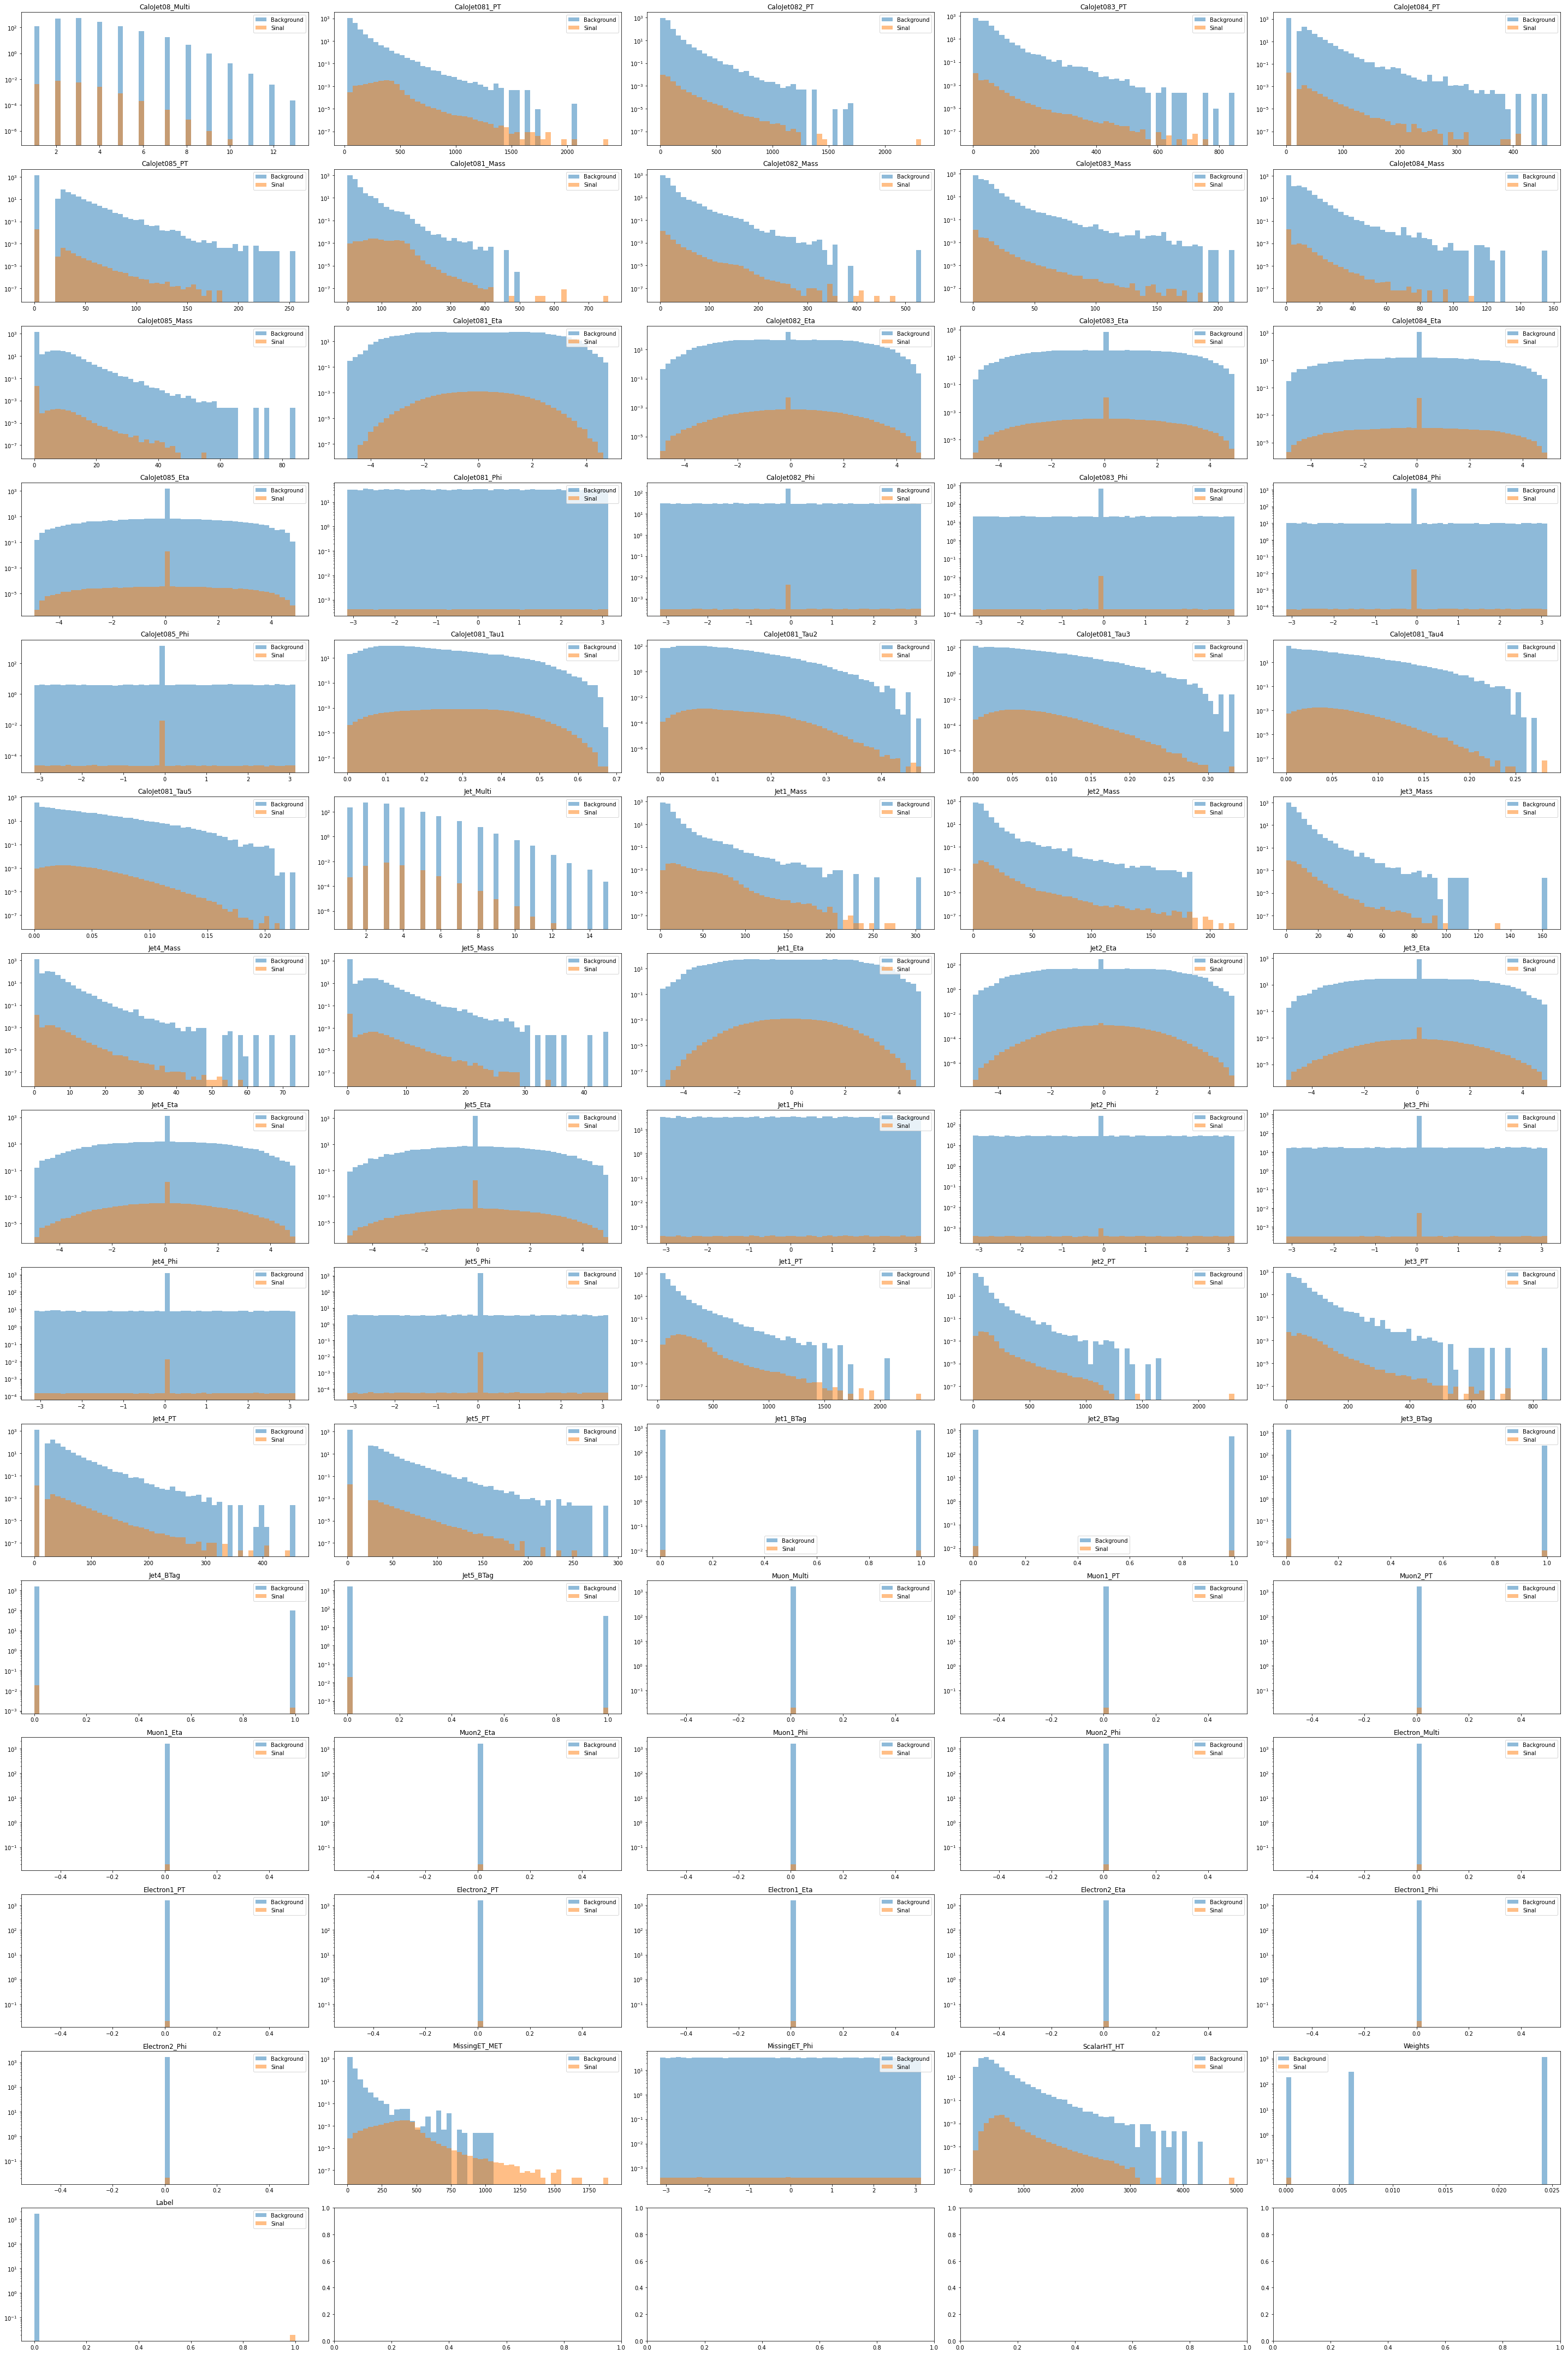

In [13]:
plot(SIGNAL_DATA,BKG_DATA)